In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# --- 1. Data Loading & Cleaning ---
print("Loading and cleaning data...")
X_normalized = pd.read_csv("crime_normalized_features.csv")
Y_normalized = pd.read_csv("crime_normalized_targets.csv")

# Replace "?" with NaN
X_normalized = X_normalized.replace("?", np.nan)
Y_normalized = Y_normalized.replace("?", np.nan)

# Convert to numeric
X = X_normalized.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(Y_normalized["ViolentCrimesPerPop"], errors="coerce")

# Combine to drop NaNs safely across both
combined = pd.concat([X, y], axis=1)

# User requested to drop columns with NaNs instead of rows
combined = combined.dropna(axis=1)

# Separate back into X and y
# Check if target is still there (it shouldn't be dropped as it has no NaNs usually, but good to be safe)
if "ViolentCrimesPerPop" not in combined.columns:
    raise ValueError("Target column 'ViolentCrimesPerPop' was dropped due to NaNs!")

y = combined["ViolentCrimesPerPop"]
X = combined.drop(columns=["ViolentCrimesPerPop"])

# Drop metadata columns that shouldn't be in PCA
cols_to_drop = ["state", "fold"]
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns], errors="ignore")

print(f"Data shape after cleaning: {X.shape}")

Loading and cleaning data...
Data shape after cleaning: (1994, 99)


In [2]:
# --- 2. PCA Analysis ---
print("\nRunning PCA...")
# PCA automatically centers the data (subtracts mean), which is crucial.
pca = PCA()
X_pca = pca.fit_transform(X)

# Variance explained
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


Running PCA...


Generating Scree Plot...


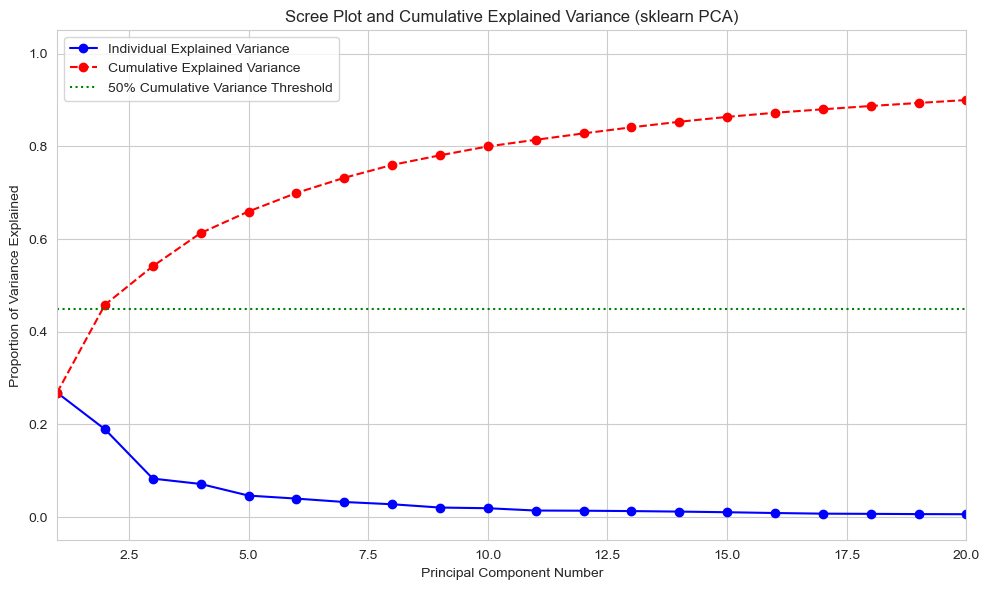

In [ ]:
# --- 3. Scree Plot ---
print("Generating Scree Plot...")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

components = range(1, len(explained_variance) + 1)
plt.plot(
    components,
    explained_variance,
    marker="o",
    linestyle="-",
    color="b",
    label="Individual Explained Variance",
)
plt.plot(
    components,
    cumulative_variance,
    marker="o",
    linestyle="--",
    color="r",
    label="Cumulative Explained Variance",
)
plt.axhline(y=0.50, color="g", linestyle=":", label="50% Cumulative Variance Threshold")

plt.title("Scree Plot and Cumulative Explained Variance (sklearn PCA)")
plt.xlabel("Principal Component Number")
plt.ylabel("Proportion of Variance Explained")
plt.legend()
plt.grid(True)
plt.xlim(1, 20)
plt.tight_layout()
plt.show()

In [4]:
# --- 4. Feature Importance (Loadings) ---
print("\nCalculating Feature Importance...")
# pca.components_ has shape (n_components, n_features)
loadings = pca.components_.T
# We only care about the first two components for this analysis
loadings_pc1_pc2 = loadings[:, :2]

# Magnitude = sqrt(PC1^2 + PC2^2)
magnitudes = np.sqrt(loadings_pc1_pc2[:, 0] ** 2 + loadings_pc1_pc2[:, 1] ** 2)

features_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "PC1_Loading": loadings_pc1_pc2[:, 0],
        "PC2_Loading": loadings_pc1_pc2[:, 1],
        "Strength": magnitudes,
    }
)

top_10 = features_df.sort_values(by="Strength", ascending=False).head(10)
print("Top 10 Features Driving PC1 and PC2:")
print(
    top_10[["Feature", "Strength", "PC1_Loading", "PC2_Loading"]].to_string(index=False)
)


Calculating Feature Importance...
Top 10 Features Driving PC1 and PC2:
            Feature  Strength  PC1_Loading  PC2_Loading
       PctRecImmig8  0.255825    -0.006481     0.255743
      PctRecImmig10  0.254200    -0.003869     0.254171
       PctRecImmig5  0.253304    -0.003422     0.253281
     PctRecentImmig  0.249099    -0.006043     0.249026
     PctForeignBorn  0.243416    -0.029213     0.241657
           pctUrban  0.236136    -0.152898     0.179951
          RentHighQ  0.233461    -0.193379     0.130799
   PctSpeakEnglOnly  0.217830    -0.021832    -0.216733
PctNotSpeakEnglWell  0.214605     0.045832     0.209654
       OwnOccMedVal  0.210410    -0.164471     0.131232


In [ ]:
# --- 5. Model Training (Linear Regression) ---
print("\n--- Linear Regression ---")

# Select components explaining 50% variance
k = np.argmax(cumulative_variance >= 0.50) + 1
print(f"Number of components selected (50% variance): {k}")

X_pca_selected = X_pca[:, :k]

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_selected, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


--- Linear Regression ---
Number of components selected (50% variance): 2
MSE: 0.0245
R2 Score: 0.4880


In [6]:
# --- 6. Model Training (Logistic Regression) ---
print("\n--- Logistic Regression ---")

# Binarize target (High vs Low Crime) based on median
threshold = y.median()
y_binary = (y > threshold).astype(int)
print(f"Binary Classification Threshold (Median): {threshold:.4f}")

# Split data for logistic regression
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_pca_selected, y_binary, test_size=0.2, random_state=42
)

log_model = LogisticRegression()
log_model.fit(X_train_log, y_train_log)

y_pred_log = log_model.predict(X_test_log)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test_log, y_pred_log):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_log, y_pred_log))


--- Logistic Regression ---
Binary Classification Threshold (Median): 0.1500
Logistic Regression Accuracy: 0.7945

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       224
           1       0.78      0.75      0.76       175

    accuracy                           0.79       399
   macro avg       0.79      0.79      0.79       399
weighted avg       0.79      0.79      0.79       399




--- Model Comparison ---
Linear Regression (Thresholded) Accuracy: 0.7093
Logistic Regression Accuracy:             0.7945
Result: Logistic Regression performed better.


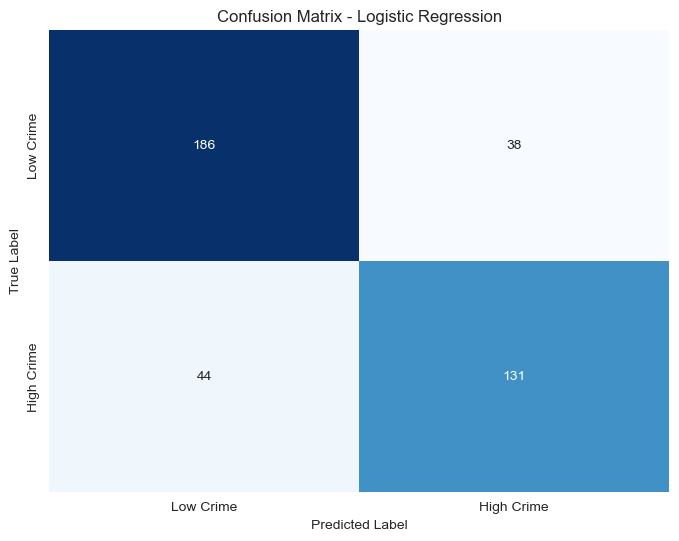

In [7]:
# --- 7. Comparison ---
print("\n--- Model Comparison ---")
# Convert Linear Regression Predictions to Binary for fair comparison
y_pred_linear_binary = (y_pred > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

linear_accuracy = accuracy_score(y_test_binary, y_pred_linear_binary)
logistic_accuracy = accuracy_score(y_test_log, y_pred_log)

print(f"Linear Regression (Thresholded) Accuracy: {linear_accuracy:.4f}")
print(f"Logistic Regression Accuracy:             {logistic_accuracy:.4f}")

if logistic_accuracy > linear_accuracy:
    print("Result: Logistic Regression performed better.")
else:
    print("Result: Linear Regression (Thresholded) performed better.")

# Confusion Matrix
cm = confusion_matrix(y_test_log, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Low Crime", "High Crime"],
    yticklabels=["Low Crime", "High Crime"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
